> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [TMDb_movie_data]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected/downloaded for analysis. Read through the description available on the homepage-links present [here](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True). List all column names in each table, and their significance. In case of multiple tables, describe the relationship between tables. 


### Question(s) for Analysis
>**Tip**: Clearly state one or more questions that you plan on exploring over the course of the report. You will address these questions in the **data analysis** and **conclusion** sections. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> **Tip**: Once you start coding, use NumPy arrays, Pandas Series, and DataFrames where appropriate rather than Python lists and dictionaries. Also, **use good coding practices**, such as, define and use functions to avoid repetitive code. Use appropriate comments within the code cells, explanation in the mark-down cells, and meaningful variable names. 

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import ast


In [40]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

    100% |████████████████████████████████| 10.5MB 3.5MB/s eta 0:00:01   31% |██████████                      | 3.3MB 27.7MB/s eta 0:00:01    70% |██████████████████████▌         | 7.4MB 28.8MB/s eta 0:00:01
    100% |████████████████████████████████| 13.4MB 2.8MB/s eta 0:00:01   14% |████▋                           | 1.9MB 28.4MB/s eta 0:00:01    24% |███████▊                        | 3.2MB 27.6MB/s eta 0:00:01    33% |██████████▉                     | 4.5MB 26.6MB/s eta 0:00:01    62% |████████████████████            | 8.4MB 26.6MB/s eta 0:00:01    81% |██████████████████████████      | 10.9MB 26.4MB/s eta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1
  Found existing installation: pandas 0.23.3
    Uninstalling pandas-0.23.3:
      Successfully uninstalled pandas-0.23.3


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [150]:
df_imdb = pd.read_csv('tmdb-movies.csv')


### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [151]:
df_imdb.shape

(10866, 21)

In [152]:
df_imdb.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [153]:
df_imdb.duplicated().sum()

1

In [154]:
df_imdb.drop_duplicates(inplace=True)

In [155]:
df_imdb.dtypes

id                        int64
imdb_id                  object
popularity              float64
budget                    int64
revenue                   int64
original_title           object
cast                     object
homepage                 object
director                 object
tagline                  object
keywords                 object
overview                 object
runtime                   int64
genres                   object
production_companies     object
release_date             object
vote_count                int64
vote_average            float64
release_year              int64
budget_adj              float64
revenue_adj             float64
dtype: object

In [156]:
df_imdb.drop(['id', 'imdb_id', 'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview', 'runtime', 'production_companies', 'release_date', 'vote_count'], axis = 1, inplace = True)

In [157]:
df_imdb.head()

,popularity,budget,revenue,original_title,genres,vote_average,release_year,budget_adj,revenue_adj
0,32.985763,150000000,1513528810,Jurassic World,Action|Adventure|Science Fiction|Thriller,6.5,2015,1.379999e+08,1.392446e+09
1,28.419936,150000000,378436354,Mad Max: Fury Road,Action|Adventure|Science Fiction|Thriller,7.1,2015,1.379999e+08,3.481613e+08
2,13.112507,110000000,295238201,Insurgent,Adventure|Science Fiction|Thriller,6.3,2015,1.012000e+08,2.716190e+08
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Action|Adventure|Science Fiction|Fantasy,7.5,2015,1.839999e+08,1.902723e+09
4,9.335014,190000000,1506249360,Furious 7,Action|Crime|Thriller,7.3,2015,1.747999e+08,1.385749e+09


In [158]:
df_imdb.isnull().sum()

popularity         0
budget             0
revenue            0
original_title     0
genres            23
vote_average       0
release_year       0
budget_adj         0
revenue_adj        0
dtype: int64

In [159]:
df_imdb.shape

(10865, 9)

In [160]:
df_imdb.dropna(inplace=True)

In [161]:
df_imdb.shape

(10842, 9)

In [162]:
df_imdb.dtypes

popularity        float64
budget              int64
revenue             int64
original_title     object
genres             object
vote_average      float64
release_year        int64
budget_adj        float64
revenue_adj       float64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa835ceb518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa837d60b00>]], dtype=object)

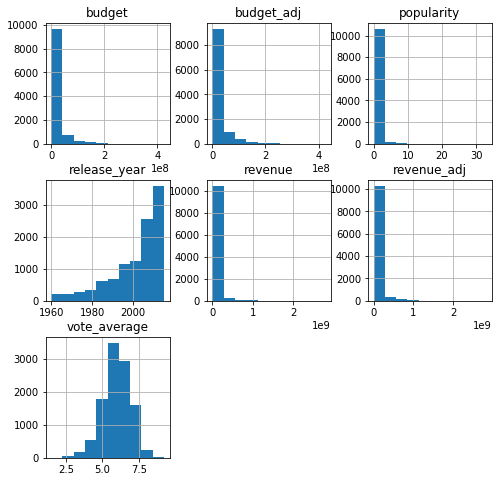

In [163]:
df_imdb.hist(figsize=(8, 8))

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### Research Question 1 (Which genres are most popular from year to year? )

In [164]:
df_imdb.genres.nunique()

2039

In [165]:
df_imdb.release_year.unique()

array([2015, 2014, 1977, 2009, 2010, 1999, 2001, 2008, 2011, 2002, 1994,
       2012, 2003, 1997, 2013, 1985, 2005, 2006, 2004, 1972, 1980, 2007,
       1979, 1984, 1983, 1995, 1992, 1981, 1996, 2000, 1982, 1998, 1989,
       1991, 1988, 1987, 1968, 1974, 1975, 1962, 1964, 1971, 1990, 1961,
       1960, 1976, 1993, 1967, 1963, 1986, 1973, 1970, 1965, 1969, 1978,
       1966])

In [166]:
genre_array = df_imdb.genres.values
genre_array = genre_array.astype('U')
split_genre = np.core.defchararray.split(a = genre_array, sep = '|')

In [167]:
split_genre

array([['Action', 'Adventure', 'Science Fiction', 'Thriller'],
       ['Action', 'Adventure', 'Science Fiction', 'Thriller'],
       ['Adventure', 'Science Fiction', 'Thriller'], ...,
       ['Mystery', 'Comedy'], ['Action', 'Comedy'], ['Horror']], dtype=object)

In [168]:
total_words = 0
max_length = 0

for index, row in enumerate(split_genre):
    for word in split_genre[index]:
        total_words += 1
        if len(word) > max_length:
            max_length = len(word)

In [169]:
combined_genre = np.empty((1, total_words), dtype = ('U' + str(max_length)))
combined_genre.shape

(1, 26955)

In [170]:
count = 0

for index, row in enumerate(split_genre):
    row_list = ast.literal_eval(str(row))
    
    for word in row_list:
        combined_genre[0, count] = word
        count += 1

In [171]:
combined_genre

array([['Action', 'Adventure', 'Science Fiction', ..., 'Action', 'Comedy',
        'Horror']], 
      dtype='<U15')

In [172]:
genre_list = np.unique(combined_genre)

In [173]:
action_df = df_imdb.loc[df_imdb.genres.str.contains('Action')]
adventure_df = df_imdb.loc[df_imdb.genres.str.contains('Adventure')]
animation_df = df_imdb.loc[df_imdb.genres.str.contains('Animation')]
comedy_df = df_imdb.loc[df_imdb.genres.str.contains('Comedy')]
crime_df = df_imdb.loc[df_imdb.genres.str.contains('Crime')]
documentary_df = df_imdb.loc[df_imdb.genres.str.contains('Documentary')]
drama_df = df_imdb.loc[df_imdb.genres.str.contains('Drama')]
family_df = df_imdb.loc[df_imdb.genres.str.contains('Family')]
fantasy_df = df_imdb.loc[df_imdb.genres.str.contains('Fantasy')]
foreign_df = df_imdb.loc[df_imdb.genres.str.contains('Foreign')]
history_df = df_imdb.loc[df_imdb.genres.str.contains('History')]
horror_df = df_imdb.loc[df_imdb.genres.str.contains('Horror')]
music_df = df_imdb.loc[df_imdb.genres.str.contains('Music')]
mystery_df = df_imdb.loc[df_imdb.genres.str.contains('Mystery')]
romance_df = df_imdb.loc[df_imdb.genres.str.contains('Romance')]
science_fiction_df = df_imdb.loc[df_imdb.genres.str.contains('Science Fiction')]
tv_movie_df = df_imdb.loc[df_imdb.genres.str.contains('TV Movie')]
thriller_df = df_imdb.loc[df_imdb.genres.str.contains('Thriller')]
war_df = df_imdb.loc[df_imdb.genres.str.contains('War')]
western_df = df_imdb.loc[df_imdb.genres.str.contains('Western')]

In [174]:
genre_count = []
for genre in genre_list:
    temp = genre.lower() + "_df"
    temp = temp.replace(" ", "_")
    number = len(eval(temp + '.index'))
    
    genre_count.append([temp[:-3], number])
    
genre_count.sort(key = lambda x:x[1], reverse = True)

for index, genre in enumerate(genre_count):
    genre_count[index] = [genre[0].title().replace("_", " "), genre[1]]

print(genre_count)


[['Drama', 4760], ['Comedy', 3793], ['Thriller', 2907], ['Action', 2384], ['Romance', 1712], ['Horror', 1637], ['Adventure', 1471], ['Crime', 1354], ['Family', 1231], ['Science Fiction', 1229], ['Fantasy', 916], ['Mystery', 810], ['Animation', 699], ['Documentary', 520], ['Music', 408], ['History', 334], ['War', 270], ['Foreign', 188], ['Tv Movie', 167], ['Western', 165]]


Text(0,0.5,'Number of Movies')

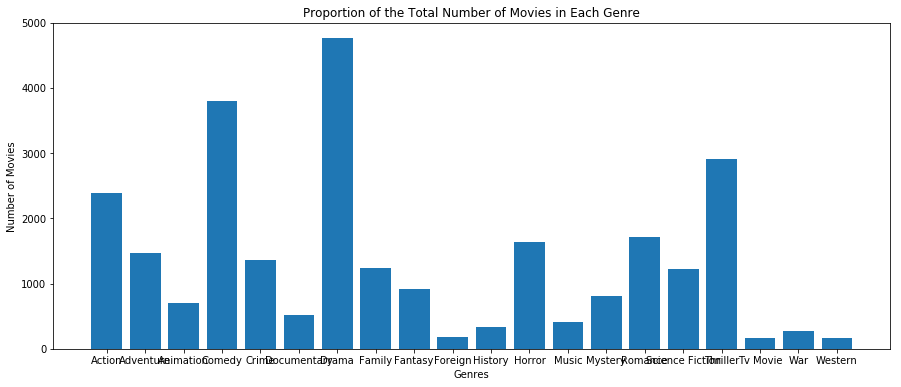

In [175]:
plt.subplots(figsize=(15, 6))
x, y = [*zip(*genre_count)]
plt.bar(x, y)
plt.title('Proportion of the Total Number of Movies in Each Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')

In [176]:
years = df_imdb['release_year'].unique()
years.sort()
print(years)

[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


In [189]:
result_rows = ['popularity_mean', 'budget_mean', 'revenue_mean']

for year in years:
    result_rows.append(str(year) + '_popularity')
    result_rows.append(str(year) + '_budget')
    result_rows.append(str(year) + '_revenue')
    
results_df = pd.DataFrame(index = result_rows, columns = genre_list)


In [190]:
for genre in genre_list:
    # Create the string to eval the dataframe of the current genre's movies.
    genre_df = genre.lower().replace(' ', '_') + '_df'
    
    # Set the overall means for the vote_average, budget_adj, and the revenure_adj columns, and calculate the overall profit mean.
    results_df.at['popularity_mean', str(genre)] = eval(genre_df)['popularity'].mean()
    results_df.at['budget_mean', str(genre)] = eval(genre_df)['budget'].mean()
    results_df.at['revenue_mean', str(genre)] = eval(genre_df)['revenue'].mean()
    
    # Set these four values for each year.
    for year in years:
        temp_year_df = eval(genre_df).loc[eval(genre_df)['release_year'] == year]
        results_df.at[str(year) + '_popularity', str(genre)] = temp_year_df['popularity'].mean()
        results_df.at[str(year) + '_budget', str(genre)] = temp_year_df['budget'].mean()
        results_df.at[str(year) + '_revenue', str(genre)] = temp_year_df['revenue'].mean()


In [191]:
results_df = results_df.apply(pd.to_numeric, axis = 1, errors = 'coerce')

In [192]:
results_df.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
popularity_mean,9.262744e-01,1.154259e+00,8.521817e-01,5.926073e-01,7.449304e-01,1.814316e-01,5.914953e-01,7.866684e-01,9.928397e-01,1.914963e-01,5.759359e-01,4.653566e-01,4.873212e-01,6.900121e-01,5.920820e-01,1.001548e+00,0.270896,7.415630e-01,7.276831e-01,5.906155e-01
budget_mean,2.772782e+07,3.754369e+07,2.315978e+07,1.329792e+07,1.766380e+07,5.771491e+05,1.188072e+07,2.335934e+07,3.261259e+07,1.451435e+06,1.859492e+07,6.226529e+06,9.438628e+06,1.611927e+07,1.253127e+07,2.497268e+07,267664.670659,1.720769e+07,2.089189e+07,1.897411e+07
revenue_mean,7.279473e+07,1.131379e+08,7.525606e+07,3.752624e+07,4.236866e+07,2.041107e+06,2.923226e+07,7.243318e+07,9.631366e+07,1.520460e+06,3.201179e+07,1.682281e+07,2.857177e+07,4.021757e+07,3.569197e+07,7.014056e+07,251497.005988,4.172842e+07,4.760518e+07,2.856871e+07
1960_popularity,5.907245e-01,7.009808e-01,NaN,3.960004e-01,3.464795e-01,NaN,5.663052e-01,2.780637e-01,4.282475e-01,1.949480e-01,4.123642e-01,5.914496e-01,4.235310e-01,NaN,5.412275e-01,3.279047e-01,NaN,8.119100e-01,2.258635e-01,5.677590e-01
1960_budget,1.750000e+06,5.500000e+05,NaN,7.537500e+05,0.000000e+00,NaN,1.215919e+06,0.000000e+00,3.750000e+05,0.000000e+00,2.400000e+06,1.824211e+05,0.000000e+00,NaN,1.125000e+06,3.166667e+05,NaN,3.044913e+05,0.000000e+00,3.333333e+05


In [193]:
results_max = results_df.idxmax(axis = 1)

In [197]:
popularity_average_max = results_max[0::3]
budget_average_max = results_max[1::3]
revenue_average_max = results_max[2::3]
print(popularity_average_max)

popularity_mean          Adventure
1960_popularity           Thriller
1961_popularity          Animation
1962_popularity          Adventure
1963_popularity          Animation
1964_popularity                War
1965_popularity              Music
1966_popularity          Animation
1967_popularity          Animation
1968_popularity            Mystery
1969_popularity              Crime
1970_popularity          Animation
1971_popularity             Family
1972_popularity              Crime
1973_popularity          Animation
1974_popularity            Mystery
1975_popularity          Adventure
1976_popularity              Crime
1977_popularity             Action
1978_popularity              Music
1979_popularity             Action
1980_popularity    Science Fiction
1981_popularity          Adventure
1982_popularity                War
1983_popularity          Adventure
1984_popularity             Family
1985_popularity             Family
1986_popularity          Adventure
1987_popularity     

Text(0,0.5,'Number of Years')

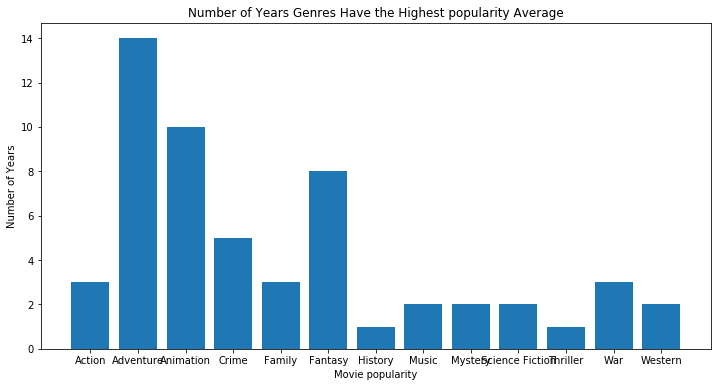

In [198]:
plt.subplots(figsize=(12, 6))
vote_x = popularity_average_max[1:].value_counts().index.values.tolist()
vote_y = popularity_average_max[1:].value_counts().tolist()
plt.bar(vote_x, vote_y)
plt.title('Number of Years Genres Have the Highest popularity Average')
plt.xlabel('Movie popularity')
plt.ylabel('Number of Years')

### Research Question 2  (What kinds of properties are associated with movies that have high revenues?)

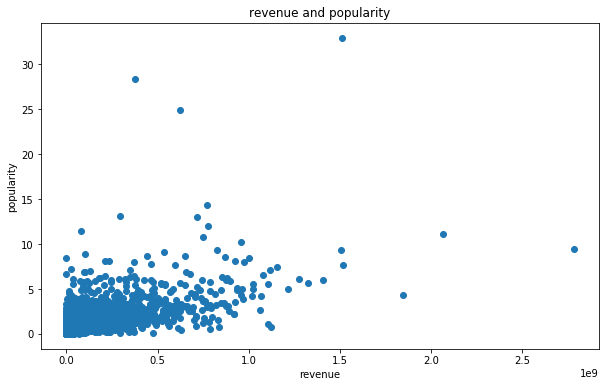

In [207]:
plt.figure(figsize = (10, 6))
plt.title('revenue and popularity')
plt.xlabel("revenue")
plt.ylabel('popularity')
plt.scatter(df_imdb['revenue'], df_imdb['popularity'])


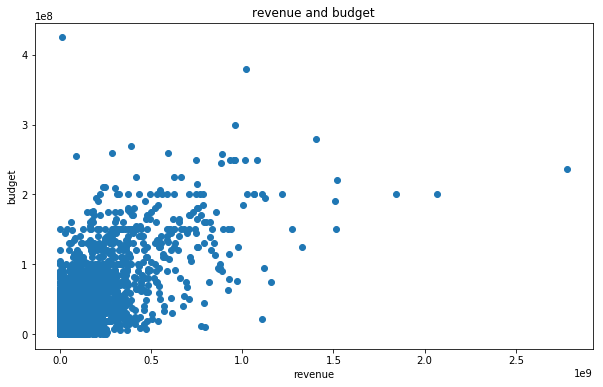

In [210]:
plt.figure(figsize = (10, 6))
plt.title('revenue and budget')
plt.xlabel("revenue")
plt.ylabel('budget')
plt.scatter(df_imdb['revenue'], df_imdb['budget'])


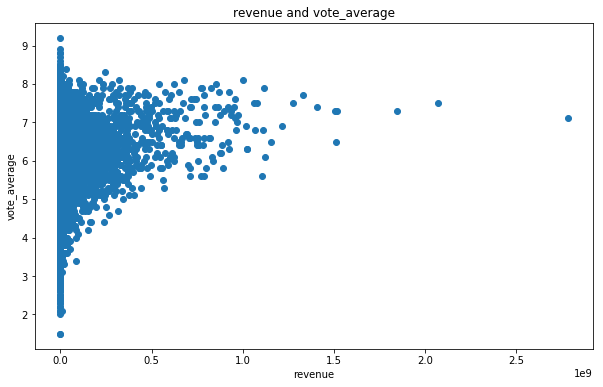

In [211]:
plt.figure(figsize = (10, 6))
plt.title('revenue and vote_average')
plt.xlabel("revenue")
plt.ylabel('vote_average')
plt.scatter(df_imdb['revenue'], df_imdb['vote_average'])


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.

> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 

> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [212]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0